# Exercise 2 - Group 2303

- Veronica Bedin, 2097013
- Roben Bhatti, 2091187
- Diego Bonato, 2091250
- Michail Sapkas, 2072109

# How to use RBM class

### Class methods:

**rbm** ( *data, hidden_units=2, SPINS=True, random_seed=2303* )
- Initializes a Restricted Boltzmann Machine instance.

*example*: my_rbm = rbm.( *args* )

1. data: Expects the user to give the whole dataset. The class will automatically compute the visible layer needed.
2. hidden_units: Specify the number of hidden units
3. SPINS: True for usage of spin notation {-1,1}, False for {0,1} respresentation
4. random_seed: Passes the random seed

**object_instance.train** ( *epochs=100, learning_rate=1.0, power_law=True, bach_size=500, cd=0, optimizer='sgd', verbose=True, epsilon=2, gamma=0.9, keep_best=True* ) 
- Trains the instanciated object on the data passed at initialization

*example*: my_rbm.train( *args* )

1. epochs: How many epochs to train on
2. learning_rate: Learning rate hyperparameter. For SGD should use 1, for ADAM less than 1
3. power_law: Only avaible with SGD. True if to be used, False for not
4. batch_size: Minibatch size to be used
5. cd: Number of contrastive divergence steps to be used. If cd < 1 , only 1 step will be used
6. optimizer: Avaible options, given as strings, are:
    1. 'sgd' 
    2. 'adam'
    3. 'adagrad'
    4. 'rmsprop'
7. verbose: If True will output learning rate and a graph during training
8. epsilon: If choose ADAM for optimizer the user can tune the epsilon hyperparameter
9. gamma: If choose RMSprop for optimizer the user can tune the epsilon hyperparameter
10. keep_best: If True, it tracks the weights and biases that gave the max energy and replaces them at the end of the training

**object_instance.generate** ( *amplify=40, one_hot=True* )
- Once trained, generates data from the model

1. aplify: How much to apply amplification of the energy in data generation
2. one_hot: if True preserves the one hot enconding, if False it doesn't care

**object_instance.accuracy** ( *gen_data* )
- Since we have knowledge if how the data should be, we can compare the generated data with the ideal case of N-P-N-P-N or P-N-P-N-P chains and get an accuracy.

1. gen_data: expects the generated data to be passed as an argument

**object_instance.plot_denoised** ( *fname, generated_data, n_rows=12, block_size=4, polar=False* )
- Once data have been generated, using the above method, attempts to plot the original and generated (denoised) data

1. fname: expectes the filename generated in the original code - use the custom loading data function to aquire fname
2. generated_data: after using the generate method, pass the generated data here
3. n_rows: how many rows to plot
4. block_size: number of columns to use to define a "block". Not relevant if polar=False
5. polar: if True, applies the N-P representation of the data. Very usefull to visually explore errors. 

### Class variables:
- This is a list of all the variable tracked by the model. The user can extract usefull information by invoking:

**object_instance.VARIABLE**

- The list of variables tracked by the model are:
1. w (weights)
2. a (visible layer biases)
3. b (hidden layer biases)
4. optimizer_title (used optimizer name)
5. energy_model (energy of the model at the end of each mini batch)
6. energy_data (energy of the data at the end of each mini batch)
7. log_likelihood (the log likelihood at the end of each epoch)
8. entropy (the entropy at the end of each epoch)


### For plotting the graphs:

- The epoch argument only affects the title of the graph.

**object_instance.plot_graph** ( *epoch* )
- Plots vertical graph. Used by train method, if verbose=True. Needs input epoch.

**object_instance.plot_weights_inblock** ( *SPINS* )
- Specify SPINS=True or SPINS=False to correctly title the graph

**object_instance.plot_weights** ( *SPINS* )
- Specify SPINS=True or SPINS=False to correctly title the graph



Importing the RBM class and the libraries used

In [1]:
from RBM import rbm

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import display_html 
import pandas as pd
import itertools
import seaborn as sns
plt.rcParams['font.size'] = 14

This custom function loads the data and also returns the filename necessery for plotting

In [2]:
def load_data(CASE):
    if CASE==0: dname="DATA"
    if CASE==1: dname="DATA_b"

    fname=dname+'/x_RBM_q0.1.dat'
    # loading data: each row is a list of visible units
    # NOTE: data "x" here is named "v" for "visible"
    v = np.loadtxt(fname, delimiter=" ",dtype=int)
    return v , fname

Also some custom functions to plot energies, log likelihood and entropy

In [3]:
def plot_energies(model, title):  
    x = np.linspace(0,50,len(model.energy_model))
    mean = np.mean(model.energy_model)
    #asy = model.energy_model[-1]
        
    plt.plot(x,model.energy_model,label='Model', linewidth=1.3)
    plt.plot(x,model.energy_data,label='Data', linewidth=1.3)
    plt.plot(x,np.full(len(x),mean),'--',label='Model Mean',c='r',linewidth=1.5)
    #plt.plot(x,np.full(len(x),asy),'--',label='asy_model',c='y',linewidth=0.8)

    plt.title(title)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Energy')
    plt.show()
        
def plot_log_likelihood(model, title):
    x = np.arange(len(model.log_likelihood))
    mean = np.mean(model.log_likelihood)
    asy = model.log_likelihood[-1]
        
    plt.plot(model.log_likelihood,label='Log Likelihood', linewidth=1.3)
    plt.plot(x,np.full(len(x),asy),'-.',label='Convergence',c='red',linewidth=1.5)
    #plt.plot(x,np.full(len(x),mean),'--',label='mean_log_likelihood',c='orange',linewidth=1.5)
        
    plt.title(title)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Log Likelihood')
    #plt.yticks([-9,-8,-7,model.log_likelihood[-1]])
    plt.show()

def plot_entropy(model, title):
    x = np.arange(len(model.entropy))
    mean = np.mean(model.entropy)
    asy = model.entropy[-1]
        
    plt.plot(model.entropy,label='Entropy')
    plt.plot(x,np.full(len(x),asy),'-.',label='Convergence',c='red',linewidth=1.5)
    #plt.plot(x,np.full(len(x),mean),'--',label='mean_entropy',c='orange',linewidth=1.5)
        
    plt.title(title)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Entropy')
    #plt.yticks([0.01,0.02,0.03,model.entropy[-1]])
    plt.show()


# Implementation of different gradient descent optimizers.
## Adam, Adagrad, RMSprop and SGD

We implemented Adam, RMSprop, Adagrad and SGD optimizers and compared the results. In order to aggregate over the performance of the optimizers we ran each for 100 different random seeds. For computational reasons the results were saved in a csv file. The accuracy for each optimizer is computed by comparing to the ideal case P-N-P-N-P or N-P-N-P-N (since we know the correct results a priori). The Log Likelihood is exctly computed by beeing able to exactly calculate the partition function Z.

Below, we share the algorithm used for this task. We used different hyperparameters for each model, mainly the learning rate and the epsilon value for the optimizers.

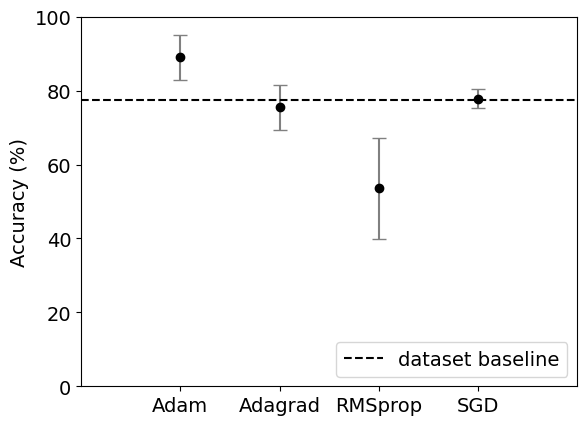

In [4]:
#csv file must be in the same path with jupyter notebook
acc_logs = pd.read_csv('acc_log_data')

madam_acc = np.mean(acc_logs['acc_adam'])
stdadam_acc = np.std(acc_logs['acc_adam'])
mada_acc = np.mean(acc_logs['acc_adagrad'])
stadada_acc = np.std(acc_logs['acc_adagrad'])
mrmsprop_acc = np.mean(acc_logs['acc_rmsprop'])
stdrmsprop_acc =  np.std(acc_logs['acc_rmsprop'])
msgd_acc = np.mean(acc_logs['acc_sgd'])
stdsgd_acc = np.std(acc_logs['acc_sgd'])

plt.errorbar('Adam', madam_acc, yerr=stdadam_acc, fmt="o",c='black',ecolor='grey',capsize=5,elinewidth=1.5)
plt.errorbar('Adagrad', mada_acc, yerr=stadada_acc, fmt="o",c='black',ecolor='grey',capsize=5,elinewidth=1.5)
plt.errorbar('RMSprop', mrmsprop_acc, yerr=stdrmsprop_acc, fmt="o",c='black',ecolor='grey',capsize=5,elinewidth=1.5)
plt.errorbar('SGD', msgd_acc, yerr=stdsgd_acc, fmt="o",c='black',ecolor='grey',capsize=5,elinewidth=1.5)

plt.axhline(y = 77.4, color = 'k', linestyle = 'dashed',label = "dataset baseline")   

#plt.xlabel('Optimizers')
plt.ylabel('Accuracy (%)')

plt.ylim(0,100)
plt.xlim(-1,4)
#plt.title('Accuracy')

plt.legend(loc='lower right')

plt.show()

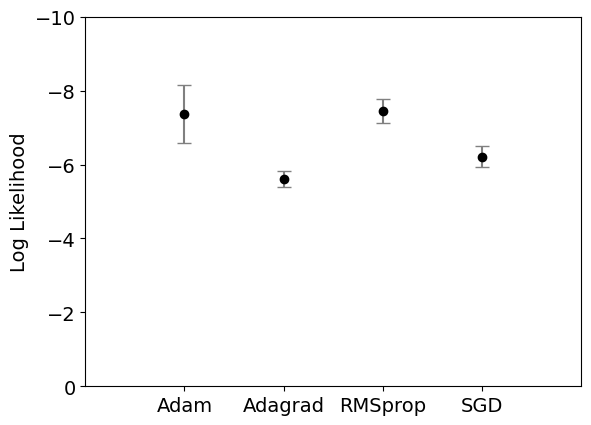

In [5]:
madam = np.mean(acc_logs['loglikhod_adam'])
stdadam = np.std(acc_logs['loglikhod_adam'])
mada = np.mean(acc_logs['loglikhod_adagrad'])
stadada = np.std(acc_logs['loglikhod_adagrad'])
mrmsprop = np.mean(acc_logs['loglikhod_rmsprop'])
stdrmsprop =  np.std(acc_logs['loglikhod_rmsprop'])
msgd = np.mean(acc_logs['loglikhod_sgd'])
stdsgd = np.std(acc_logs['loglikhod_sgd'])

plt.errorbar('Adam', madam, yerr=stdadam, fmt="o",c='black',ecolor='grey',capsize=5,elinewidth=1.5)
plt.errorbar('Adagrad', mada, yerr=stadada, fmt="o",c='black',ecolor='grey',capsize=5,elinewidth=1.5)
plt.errorbar('RMSprop', mrmsprop, yerr=stdrmsprop, fmt="o",c='black',ecolor='grey',capsize=5,elinewidth=1.5)
plt.errorbar('SGD', msgd, yerr=stdsgd, fmt="o",c='black',ecolor='grey',capsize=5,elinewidth=1.5)

plt.ylim(0,-10)
plt.xlim(-1,4)

#plt.xlabel('Optimizers')
plt.ylabel('Log Likelihood')

#plt.yticks([-10,0,madam,mada,mrmsprop,msgd])#minor=True
#plt.title('Log Likelihood')

plt.show()

Comparing the two plots above we can infer that although Adam and RMSprop have better log likehood values they differ in accuracies. In particular Adam provides a higher accuracy and converges faster (~5 epochs)

For the next part we choose to train only with the Adam optimizer.

# Exploring {0,1} and {-1,1} representation

In the rbm class this is equivilent to SPINS=False for {0,1} and SPINS=True for {-1,1} . We will preserve the one hot encoding.

# {0,1} Representation

In [6]:
data, fname = load_data(CASE=1)

In [7]:
rbm0 = rbm(data, hidden_units=3, SPINS=False, random_seed=3)

Loaded N=10000 data instances each containing L=20 digits


Epsilon must be small for the {0,1} represantation.

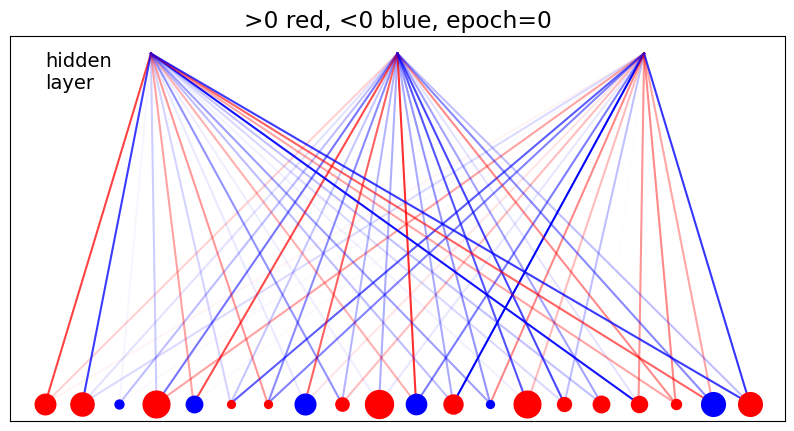

learning rate =  0.005
epoch:  1
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -6.013
epoch:  2
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -5.719
epoch:  3
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -5.62
epoch:  4
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -5.567
epoch:  5
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -5.53
epoch:  6
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -5.514
epoch:  7
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -5.501
epoch:  8
====|====|====|====|====|====|=

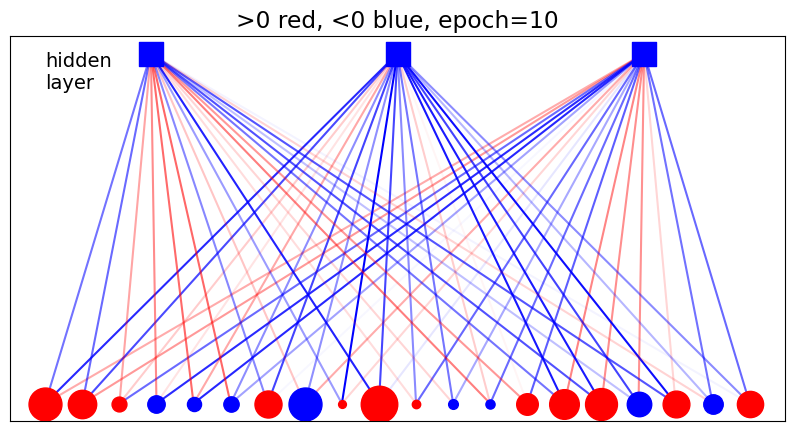

learning rate =  0.005
epoch:  11
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -5.457
epoch:  12
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -5.45
epoch:  13
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -5.442
epoch:  14
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -5.435
epoch:  15
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -5.434
epoch:  16
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -5.432
epoch:  17
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -5.427
epoch:  18
====|====|====|====|==

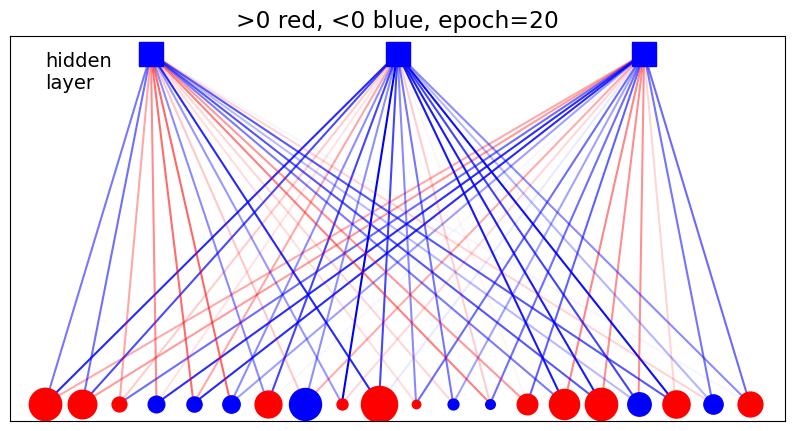

learning rate =  0.005
epoch:  21
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -5.415


In [8]:
rbm0.train(epochs=21, 
          one_hot=True, 
          learning_rate=0.005, 
          batch_size=500, 
          cd=5,
          optimizer='adam', 
          epsilon=1e-4,
          keep_best=True,
          verbose=True)

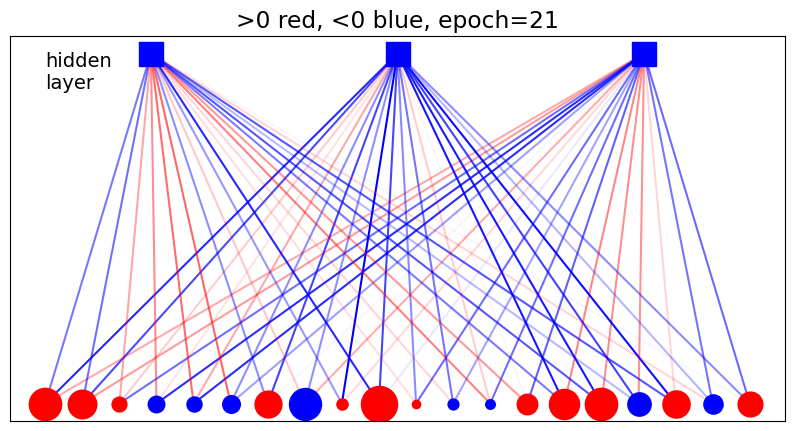

In [9]:
rbm0.plot_graph(21)

We use a 30 fold amplification to the energy in order to generate data from the trained model. Since energy is a little abstract we use the term "amplification" rather than "temperature". We imidiatelly compute the accuracy score.

In [10]:
# Generating data
gen_data = rbm0.generate(amplify=30,one_hot=True)
rbm0.accuracy(gen_data)

C:\Users\micha\Desktop\UNIPD\Semester 2\Laboratory of Computational Physics MODB\Exercise 2 - RBM\RBM.py:86: RuntimeWarning: overflow encountered in exp
  prob = 1. / (1. + np.exp(-DE*act))


Percentage error in data: 22.6 %
Accuracy of the models prediction: 82.0 %


82.41

Following, we plot the Original and the Generated/Denoised data, always preserving the one hot encoding, to visually inspect the data. We also plot in the Polar - Non-polar representation.

In [11]:
rbm0.plot_denoised(fname,gen_data,n_rows=10,polar=False)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
5,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
6,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
7,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
8,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
9,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


In [12]:
rbm0.plot_denoised(fname,gen_data,n_rows=10,polar=True)

,0,1,2,3,4
0,P,N,P,N,P
1,P,N,P,N,P
2,P,N,P,N,P
3,N,P,N,P,N
4,P,P,N,P,N
5,P,N,P,N,P
6,P,N,P,N,N
7,P,N,P,N,P
8,N,P,N,N,N
9,P,N,P,N,P


Following, we plot the weights of the RBM. We can also plot the weights with respect to blocks.

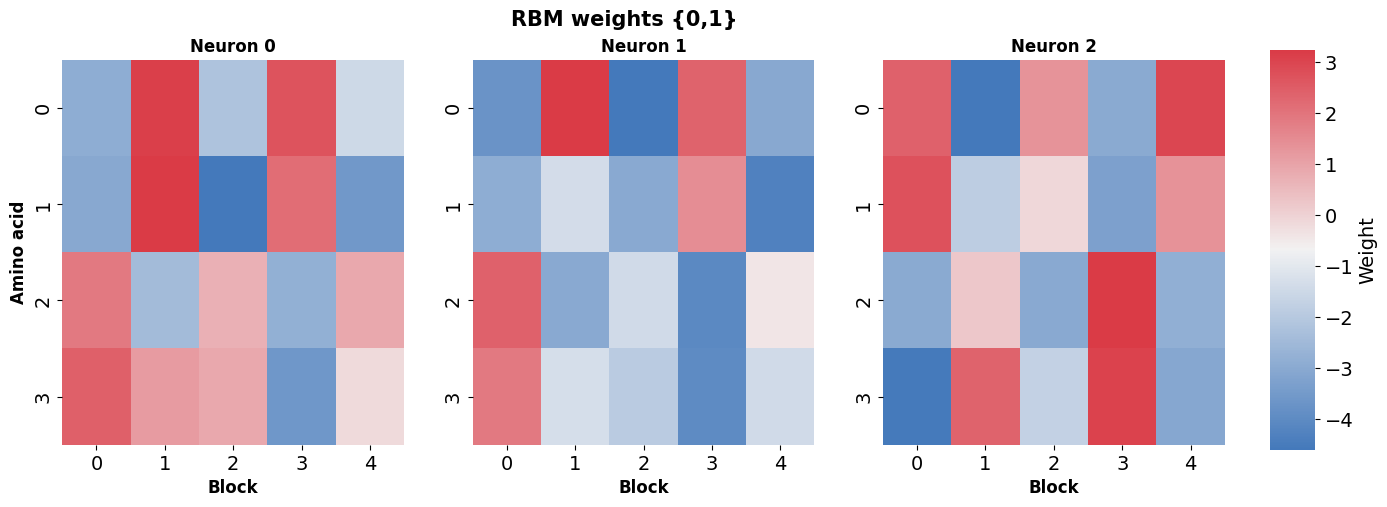

In [13]:
rbm0.plot_weights_inblocks(SPINS=False)

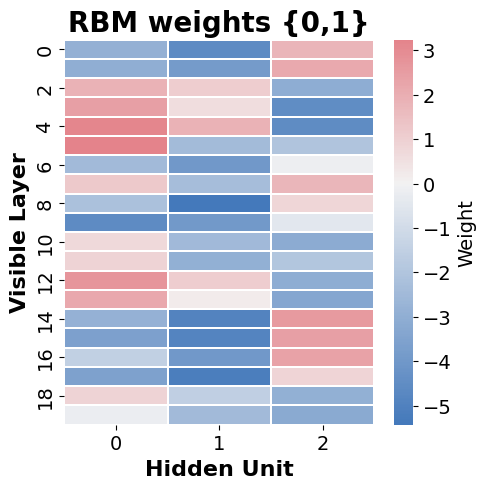

In [14]:
rbm0.plot_weights(SPINS=False)

Using the plotting functions we defined at the begining we plot the Energies of the model and the data. We observe that the energy of the model is lower that the data which is a good indicator of successful training.

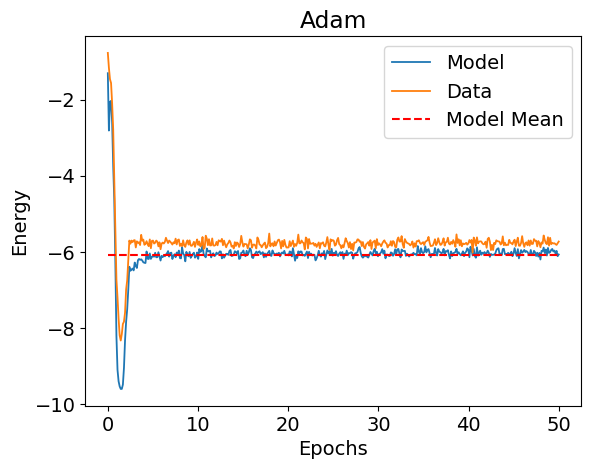

In [15]:
plot_energies(rbm0,'Adam')

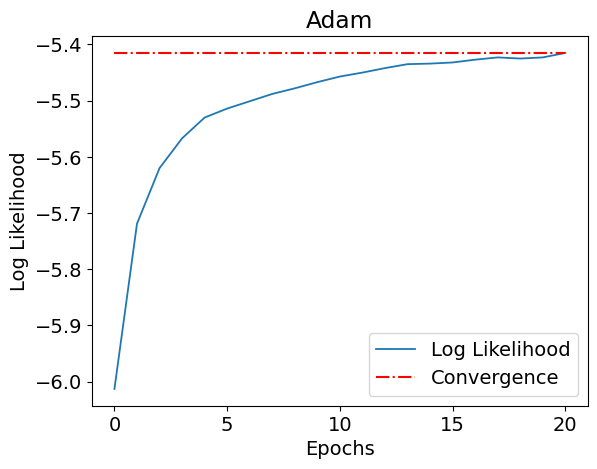

In [16]:
plot_log_likelihood(rbm0,'Adam')

Since we compute the partition function Z we can also calculate the entropy. We expected the entropy to decrease with the training, meaning that the model generates more ordered data as it learns.

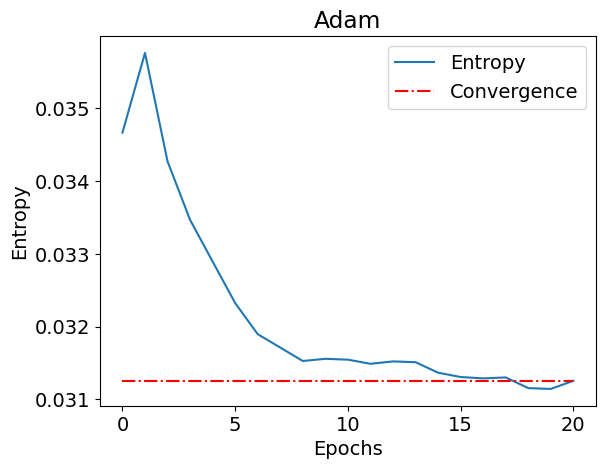

In [17]:
plot_entropy(rbm0,'Adam')

# {-1,1} Spins Representation

In [18]:
data, fname = load_data(CASE=1)

In [19]:
rbm1 = rbm(data, hidden_units=3, SPINS=True, random_seed=3)

Loaded N=10000 data instances each containing L=20 digits


Epsilon must be large for the {-1,1} represantation.

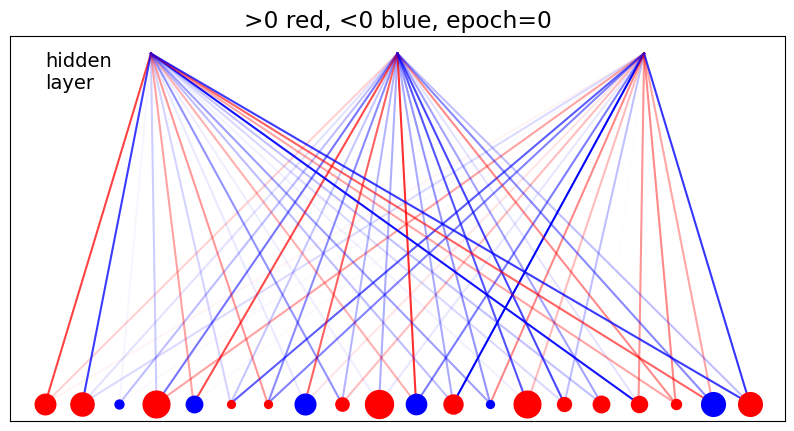

learning rate =  0.005
epoch:  1
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -10.494
epoch:  2
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -8.55
epoch:  3
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -7.898
epoch:  4
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -7.569
epoch:  5
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -7.373
epoch:  6
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -7.241
epoch:  7
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -7.147
epoch:  8
====|====|====|====|====|====

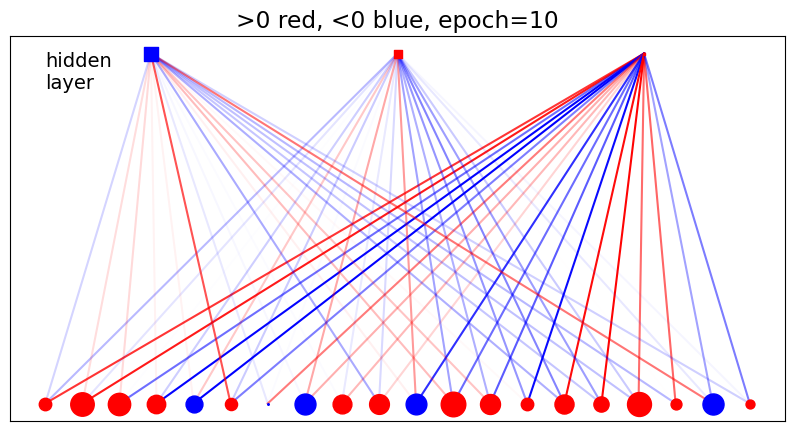

learning rate =  0.005
epoch:  11
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -6.943
epoch:  12
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -6.913
epoch:  13
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -6.888
epoch:  14
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -6.866
epoch:  15
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -6.847
epoch:  16
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -6.831
epoch:  17
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -6.816
epoch:  18
====|====|====|====|=

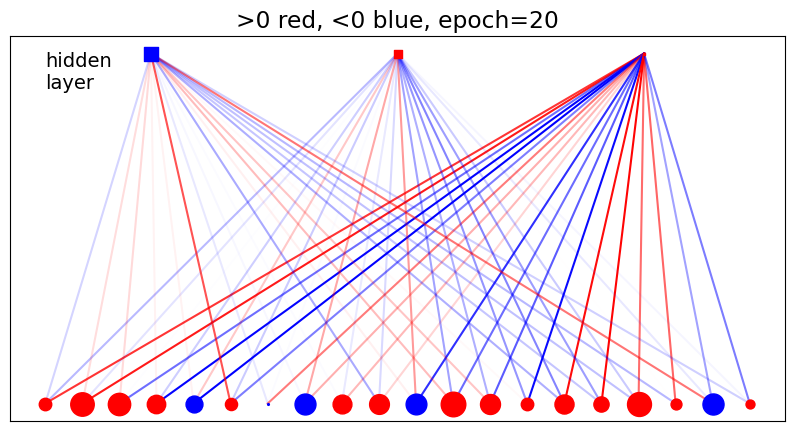

learning rate =  0.005
epoch:  21
====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|====|Log Likelihood = -6.771


In [20]:
rbm1.train(epochs=21, 
          one_hot=True, 
          learning_rate=0.005,
          batch_size=500, 
          cd=5, 
          optimizer='adam', 
          epsilon=2,
          keep_best=True,
          verbose=True)

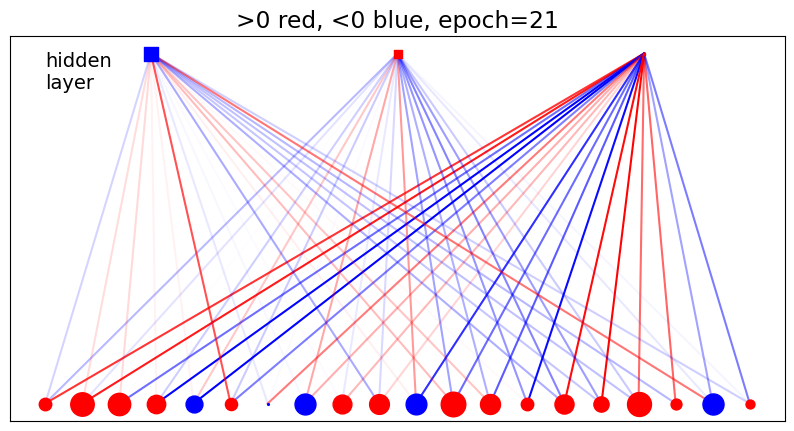

In [21]:
rbm1.plot_graph(21)

In [22]:
# Generating data
gen_data1 = rbm1.generate(amplify=30,one_hot=True)
rbm1.accuracy(gen_data1)

Percentage error in data: 22.6 %
Accuracy of the models prediction: 91.0 %


90.65

The accuracy of the {-1,1} representation is better than {0,1}. Lets see the other plots.

In [23]:
rbm1.plot_denoised(fname,gen_data1,n_rows=10,polar=False)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
2,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
5,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0
6,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
7,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1
8,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
9,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0


In [24]:
rbm1.plot_denoised(fname,gen_data1,n_rows=10,polar=True)

,0,1,2,3,4
0,P,N,P,N,P
1,P,N,P,N,P
2,P,N,P,N,P
3,N,P,N,P,N
4,P,P,N,P,N
5,P,N,P,N,P
6,P,N,P,N,N
7,P,N,P,N,P
8,N,P,N,N,N
9,P,N,P,N,P


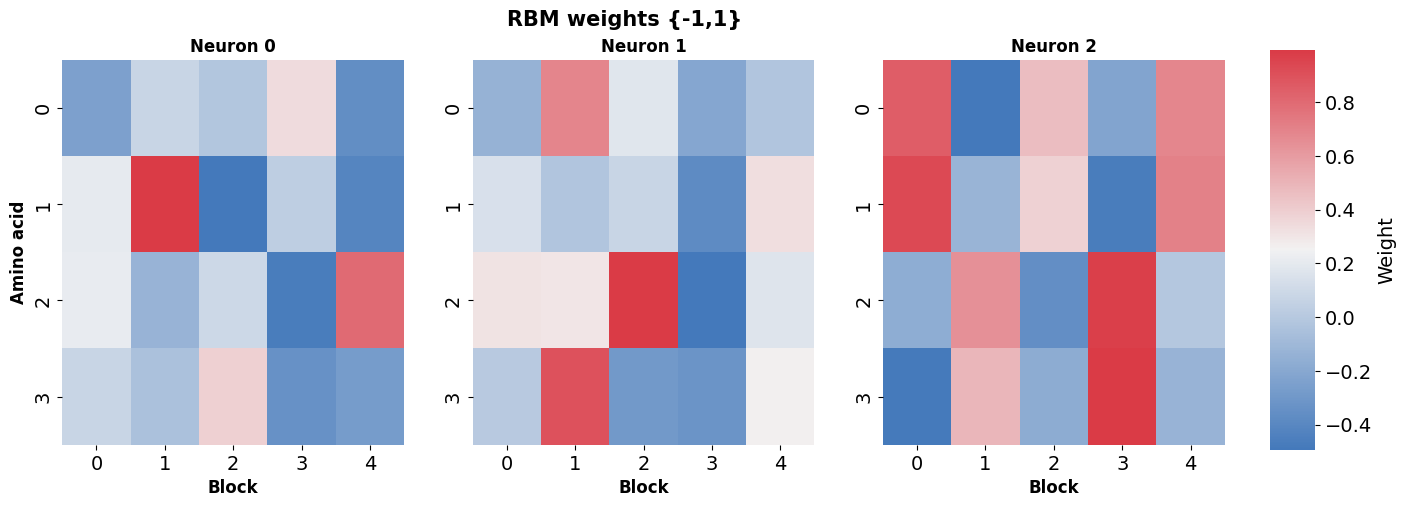

In [25]:
rbm1.plot_weights_inblocks(SPINS=True)

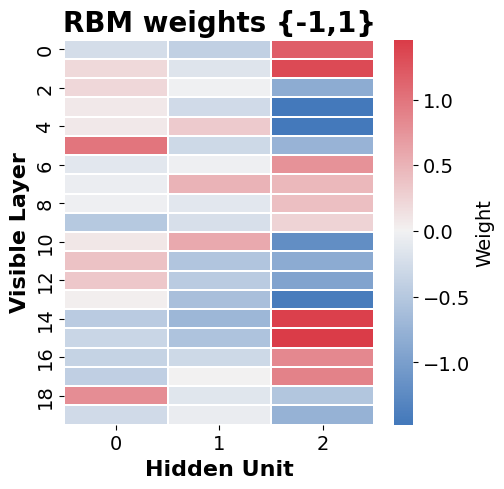

In [26]:
rbm1.plot_weights(SPINS=True)

We observe that the weights on the {-1,1} representation are smaller than the {0,1}.

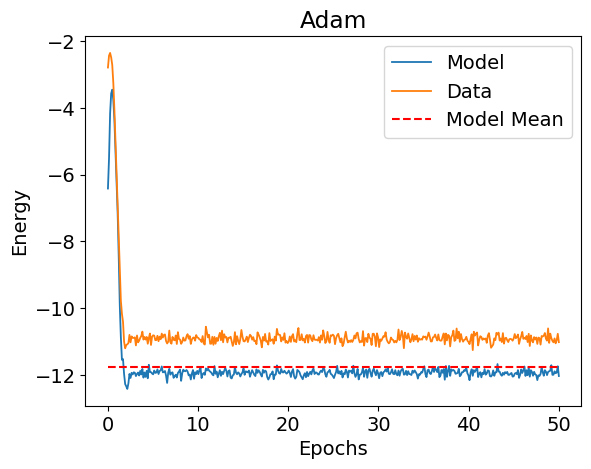

In [27]:
plot_energies(rbm1,'Adam')

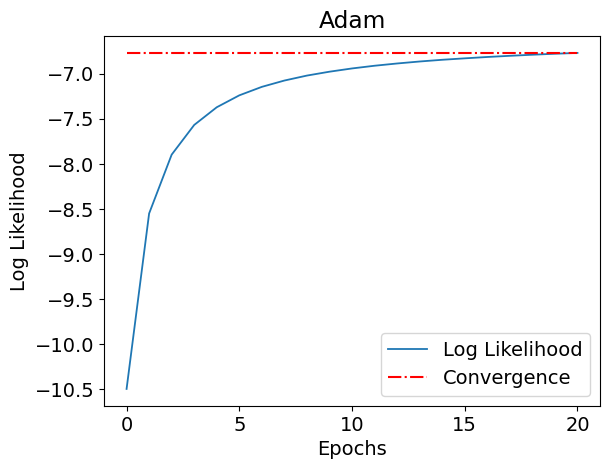

In [28]:
plot_log_likelihood(rbm1,'Adam')

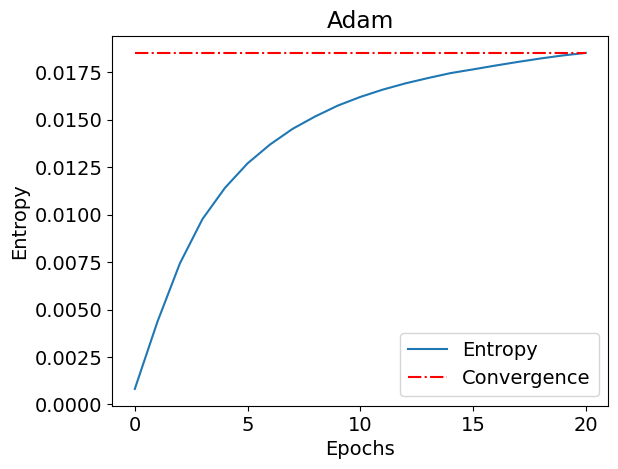

In [29]:
plot_entropy(rbm1,'Adam')

Surprise! In the {-1,1} representation the Entropy does not decrease but increases!

# Increase the number of contrastive divergence steps

We explore the accuracy and loglikelihood of Adam for 8 steps of constractive divergence. For each step, 9 different random seeds are used in order to aquire the standard statistics of mean value and std. For the sake of computational reasons we computed it once and stored the data in a csv format. The algorithm used is shared below:

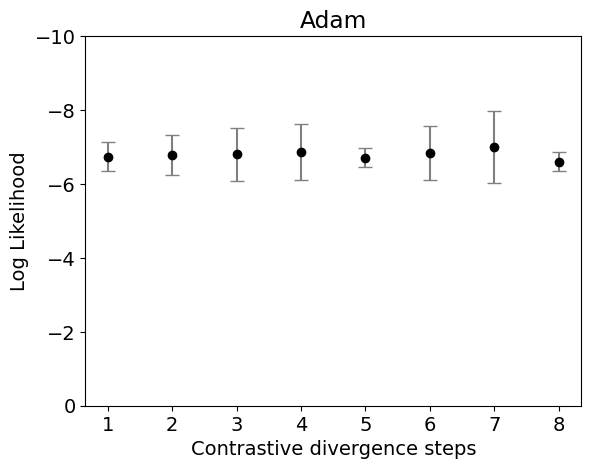

In [32]:
#csv file must be in the same path with jupyter notebook
cd_data = pd.read_csv("cd_steps_data")

meanLL = cd_data["mean_LogLikhood"]
stdLL = cd_data["std_LogLikhood"]
meanACC = cd_data["mean_acc"]
stdACC = cd_data["std_acc"]

plt.errorbar(np.arange(1,9),meanLL,yerr=stdLL,fmt='o', color='black',
             ecolor='grey', elinewidth=1.5, capsize=5)      
plt.title("Adam")
plt.xlabel('Contrastive divergence steps')
plt.ylabel('Log Likelihood')
plt.ylim((0, -10)) 
plt.show()

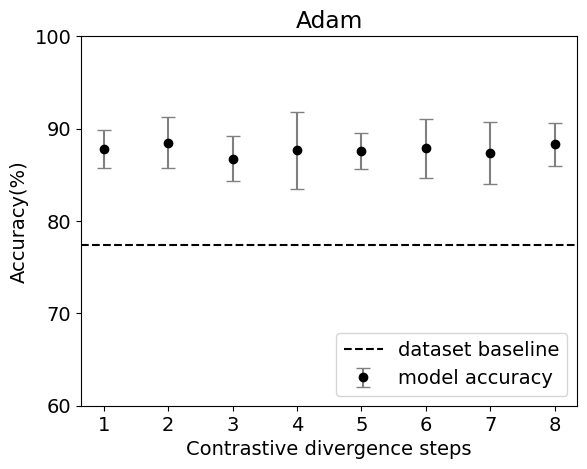

In [31]:
plt.errorbar(np.arange(1,9),meanACC,yerr=stdACC,fmt='o', color='black',
             ecolor='grey', elinewidth=1.5, capsize=5,label="model accuracy")
plt.axhline(y = 77.4, color = 'k', linestyle = 'dashed',label = "dataset baseline")    
plt.title("Adam")
plt.xlabel('Contrastive divergence steps')
plt.ylabel('Accuracy(%)')
plt.ylim((60, 100)) 
plt.legend(loc=4)
yy=[60,70,80,90,100]
plt.yticks(yy)
plt.plot() 
plt.show()

We observe that the accuracy and the Log Likehood stay constant with respect to the number of contrastive divergence steps. It is interesting to note that with steps 5 and 8 the results seem to have less deviation from the mean value. This stability, is the reason we used cd=5 in the trainings of the models. 